In [9]:
import os
import json
import shutil
import tempfile
import time
from typing import Tuple
import glob

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.networks.layers import Norm
from monai.transforms import (
    AsDiscrete,
    Activations,
    ScaleIntensityRanged,
    EnsureChannelFirstd,
    Orientationd,
    ScaleIntensityRange,
    RandCropByPosNegLabeld,
    Compose,
    RandRotate90d,
    SpatialCropd,
    KeepLargestConnectedComponent,
    Compose
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR, UNet

from monai.data import decollate_batch, DataLoader, Dataset
from functools import partial

import torch
import torch.optim as optim
import torch.nn as nn

import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

from sklearn.model_selection import train_test_split

In [10]:
model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
).to("cuda")
# load
state = torch.load('model/cleanSlidingWindowCorrected/checkpoint copy.pt')

In [11]:
def recursive_removal_module(input_dict):
    newdict = {}
    for key in input_dict.keys():
        newKey = key[7:]
        if isinstance(input_dict[key], dict):
            newdict[newKey] = recursive_removal_module(input_dict[key])
        else:
            newdict[newKey] = input_dict[key]
    return newdict

In [12]:
normal_state = recursive_removal_module(state)

In [13]:
# load
model.load_state_dict(normal_state)

<All keys matched successfully>

In [18]:
def get_loader(batch_size, data_dir, roi):
    """
    Provide data loader for training and validation data.
    """
    images = sorted(glob.glob(os.path.join(data_dir, "volume", "*.nii.gz")))
    segs = sorted(glob.glob(os.path.join(data_dir, "seg", "*.nii.gz")))

    data_dicts = [
        {"image": image_name, "label": seg_name}
        for image_name, seg_name in zip(images, segs)
    ]
    data_dicts = data_dicts[:40] # Limit data to test the pipeline

    train_files, val_files = train_test_split(data_dicts, train_size=0.8, random_state=0)

    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            SpatialCropd(keys=["image", "label"], roi_start=(70, 0, 0), roi_end=(512, 512, -1)),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            # Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
            # Probably not needed 
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(roi[0], roi[1], roi[2]),
                pos=1,
                neg=1,
                num_samples=4,
                image_key="image",
                image_threshold=0,
            ),
            ScaleIntensityRanged(
                keys=["image"],
                a_min=-1024,
                a_max=3071,
                b_min=0.0,
                b_max=1.0,
                clip=True),
        ]
    )

    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            SpatialCropd(keys=["image", "label"], roi_start=(30, 30, 0), roi_end=(512-30, 512-100, 130)),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image"
            ),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            # Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
            # Probably not needed 
            ScaleIntensityRanged(keys=["image"], a_min=-1024, a_max=3071, b_min=0.0, b_max=1.0, clip=True),
        ]
    )

    train_ds = Dataset(data=train_files, transform=train_transform)
    val_ds = Dataset(data=val_files, transform=val_transform)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=6,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=6,
        pin_memory=True,
    )

    return train_loader, val_loader

In [19]:
metric = DiceMetric(include_background=False, reduction=MetricReduction.MEAN)
roi = (128, 128, 64)

In [20]:
_, val_data = get_loader(1, "/tsi/data_education/data_challenge/train", roi)

In [21]:
len(val_data)

8

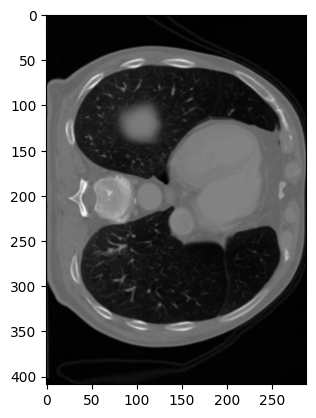

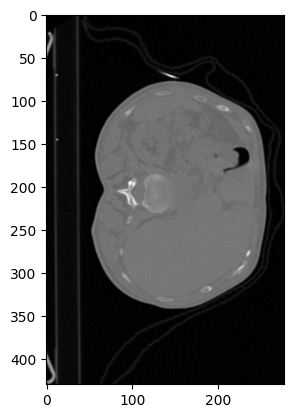

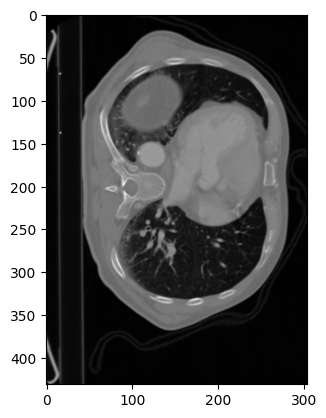

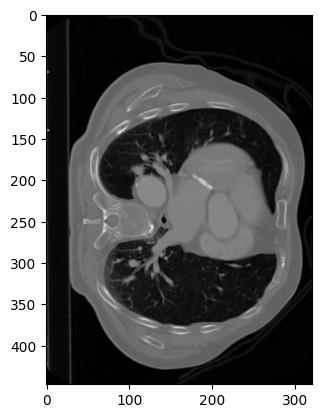

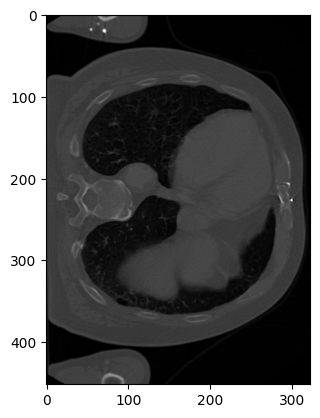

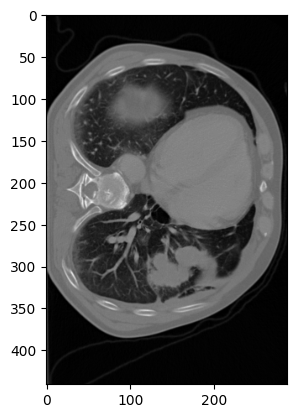

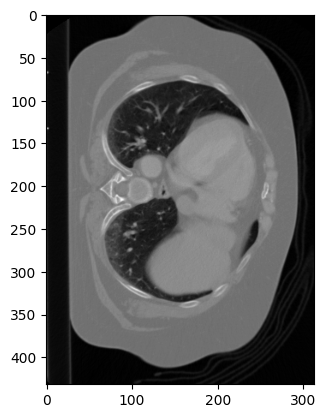

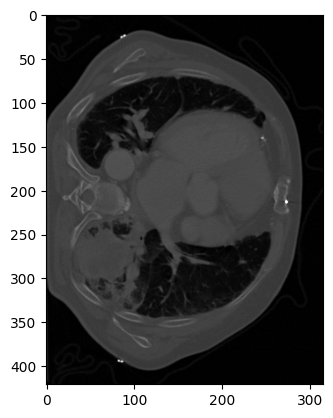

In [23]:
for data in val_data:
    inputs = data["image"]
    plt.imshow(inputs[0, 0, :, :, 30], cmap="gray")
    plt.show()

Shape of inputs before post pred:  torch.Size([1, 1, 415, 285, 130])
Shape of labels before post pred:  torch.Size([1, 1, 415, 285, 130])
Metric value:  metatensor([[0.]], device='cuda:0')
Metric shape After keeping largest component:  metatensor([[0.]], device='cuda:0')


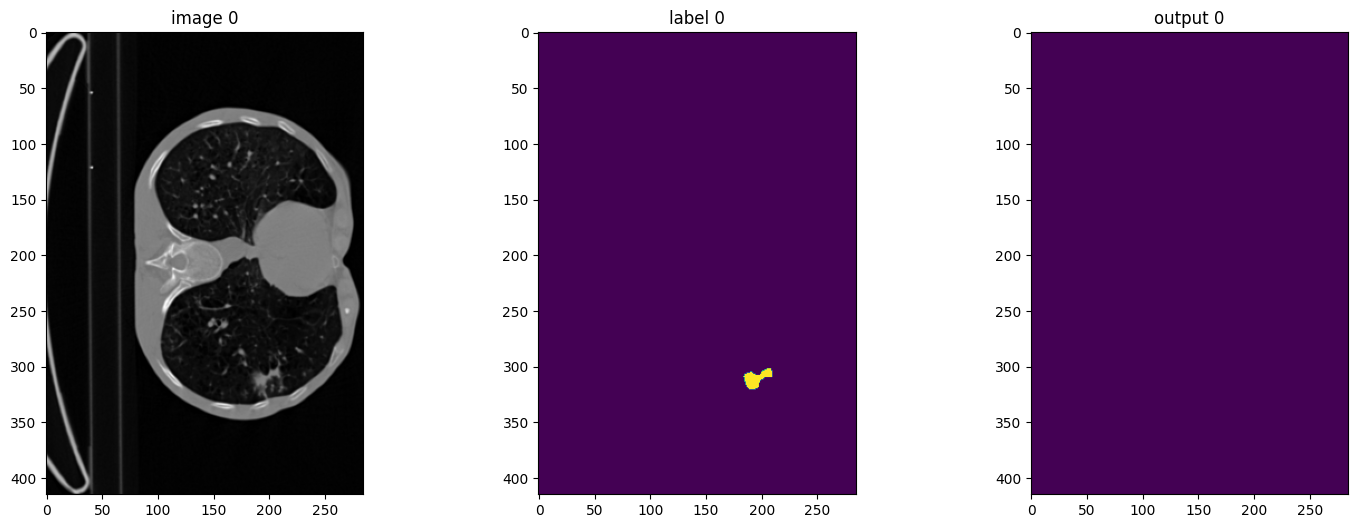

Shape of inputs before post pred:  torch.Size([1, 1, 437, 301, 130])
Shape of labels before post pred:  torch.Size([1, 1, 437, 301, 130])
Metric value:  metatensor([[0.2865]], device='cuda:0')
Metric shape After keeping largest component:  metatensor([[0.3751]], device='cuda:0')


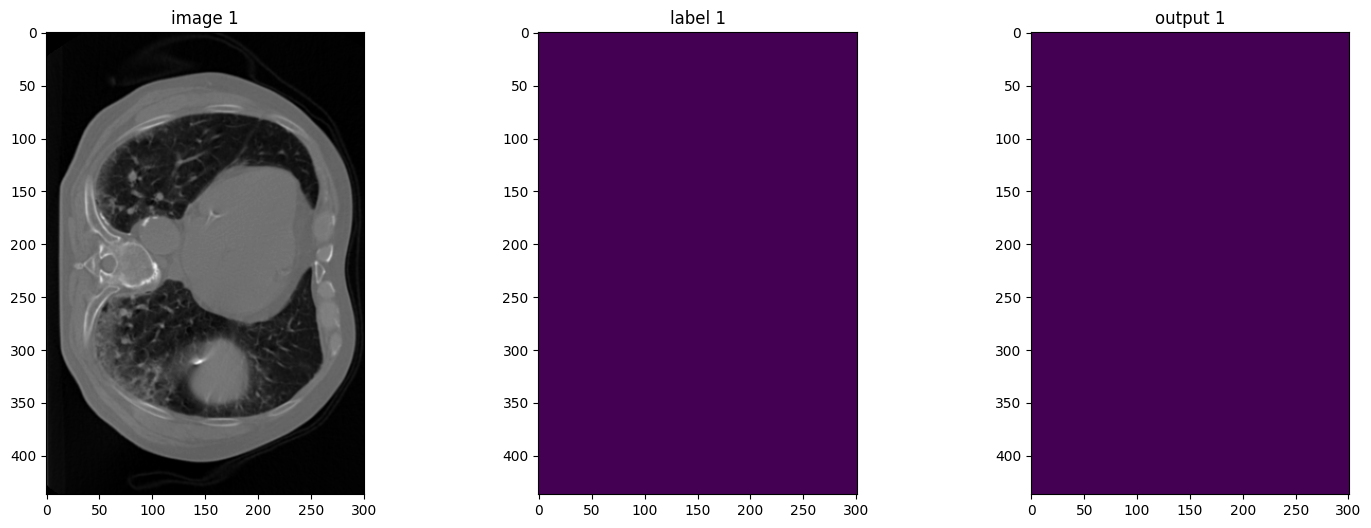

Shape of inputs before post pred:  torch.Size([1, 1, 417, 281, 90])
Shape of labels before post pred:  torch.Size([1, 1, 417, 281, 90])
Metric value:  metatensor([[0.7114]], device='cuda:0')
Metric shape After keeping largest component:  metatensor([[0.7115]], device='cuda:0')


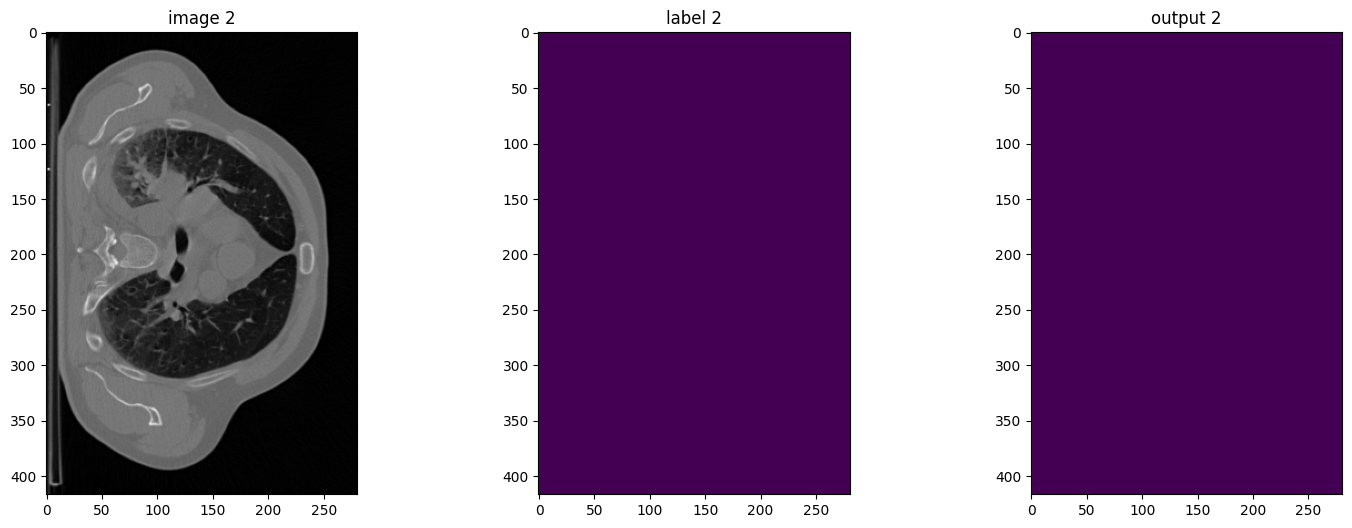

Shape of inputs before post pred:  torch.Size([1, 1, 438, 296, 126])
Shape of labels before post pred:  torch.Size([1, 1, 438, 296, 126])
Metric value:  metatensor([[0.7808]], device='cuda:0')
Metric shape After keeping largest component:  metatensor([[0.7829]], device='cuda:0')


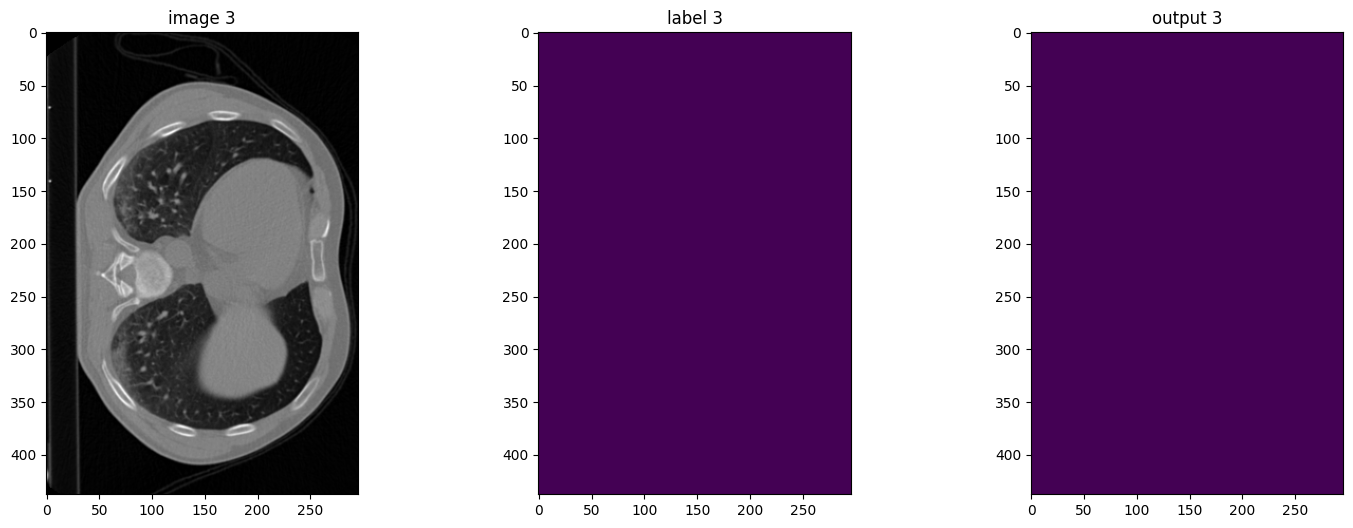

Shape of inputs before post pred:  torch.Size([1, 1, 450, 299, 130])
Shape of labels before post pred:  torch.Size([1, 1, 450, 299, 130])
Metric value:  metatensor([[0.4520]], device='cuda:0')
Metric shape After keeping largest component:  metatensor([[0.4520]], device='cuda:0')


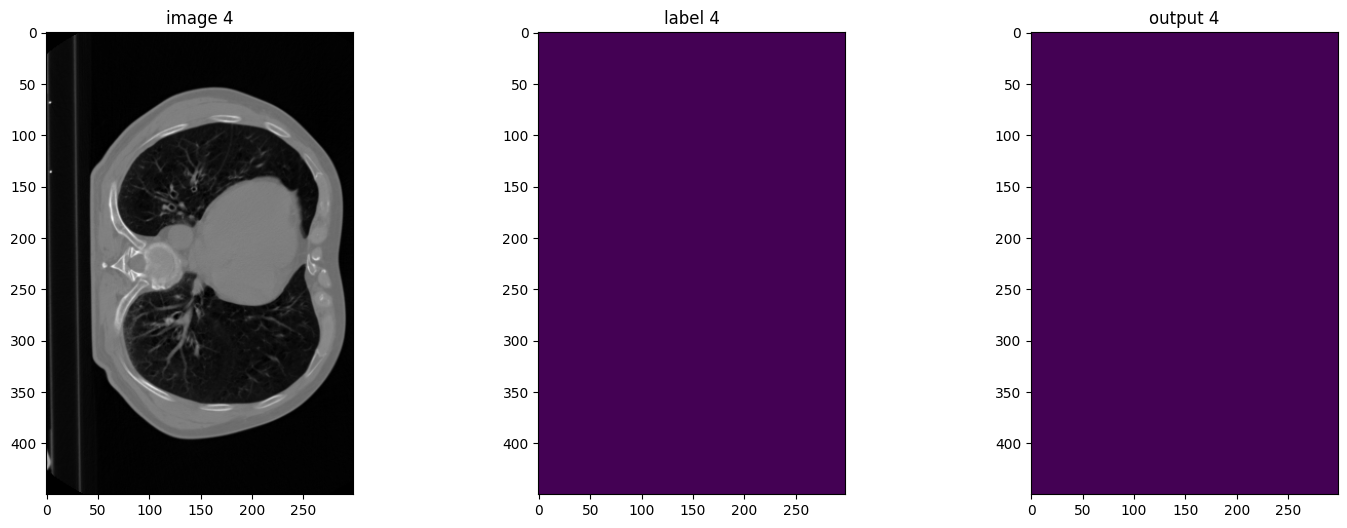

Shape of inputs before post pred:  torch.Size([1, 1, 452, 306, 130])
Shape of labels before post pred:  torch.Size([1, 1, 452, 306, 130])
Metric value:  metatensor([[0.8260]], device='cuda:0')
Metric shape After keeping largest component:  metatensor([[0.8325]], device='cuda:0')


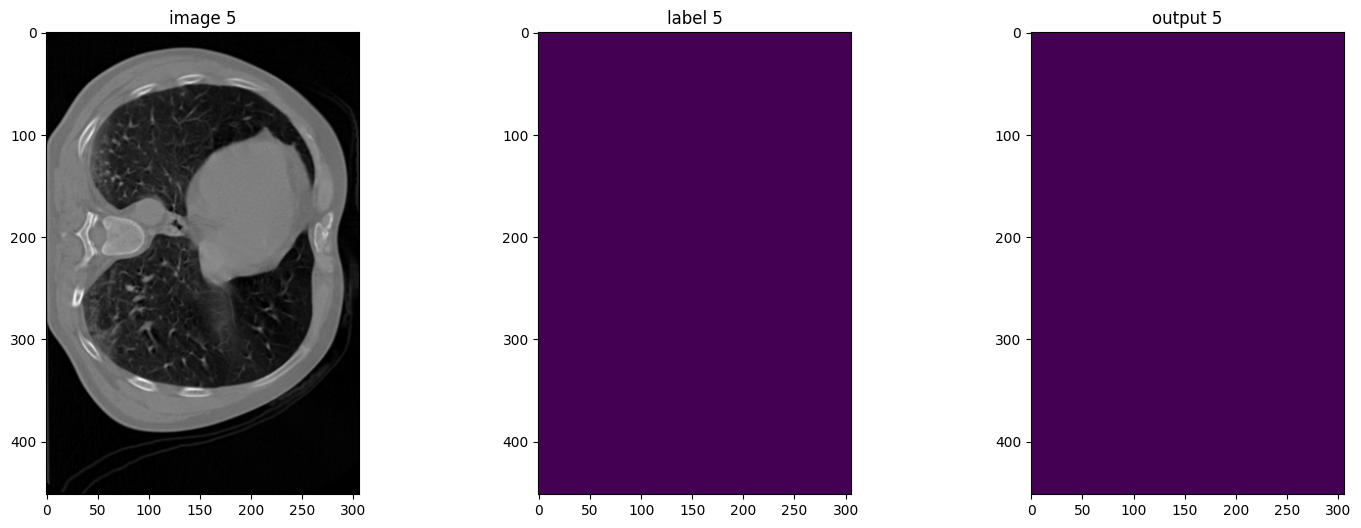

In [20]:
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
mean_metric_history = []
model.eval()
with torch.no_grad():
    for i, batch_data in enumerate(val_data):
        inputs, labels = (
            batch_data["image"].to(0),
            batch_data["label"].to(0),
        )
        print("Shape of inputs before post pred: ", inputs.shape)
        print("Shape of labels before post pred: ", labels.shape)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            inputs, roi, sw_batch_size, model
        )
        val_outputs_post = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(labels)]
        # val_outputs = torch.cat(val_outputs)
        # val_labels = torch.cat(val_labels)
        # print("Shape of inputs after post pred: ", val_outputs.shape)
        # print("Shape of labels after post pred: ", val_labels.shape)
        
        metric_value = metric(y_pred=val_outputs_post, y=val_labels)
        #print("Metric shape: ", metric_value.shape)
        print("Metric value: ", metric_value)

        post_prod_transform = Compose(
            [
                KeepLargestConnectedComponent()
            ]
        )
        #print("Shape of inputs before post prod: ", val_outputs.shape)
        val_outputs_pred = torch.argmax(val_outputs, dim=1)
        #print("Shape of inputs after post prod: ", val_outputs_pred.shape)
        val_outputs_post_prod = post_prod_transform(val_outputs_pred.unsqueeze(0)).squeeze(0)


        val_outputs_post_prod_for_metric = post_label(val_outputs_post_prod)
        val_outputs_post_prod_for_metric = val_outputs_post_prod_for_metric.unsqueeze(0)
        metric_value = metric(y_pred=val_outputs_post_prod_for_metric, y=val_labels)
        print("Metric shape After keeping largest component: ", metric_value)
        

        heigth = 50

        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(inputs[0, 0, :, :, heigth].cpu().detach(), cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(labels[0, 0, :, :, heigth].cpu().detach())
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).cpu().detach()[0, :, :, heigth])
        plt.show()

        if i == 5:
            break
    
    # Aggregate the final mean metric value
    value_metric = metric.aggregate().item()
    mean_metric_history.append(value_metric)
    metric.reset()


# Animation

In [10]:
import nibabel as nib
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML
sns.set_style("darkgrid")

In [11]:
dataIrm = list(val_data)

In [12]:
def show_irm(data: np.ndarray, inputs, val_outputs):
    # Create a figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Initialize images for each subplot
    im1 = axs[0].imshow(data[:, :, 0], cmap='gray', vmin=0, vmax=1)
    im2 = axs[1].imshow(inputs[:, :, 0], vmin=0, vmax=1)
    im3 = axs[2].imshow(val_outputs[:, :, 0], vmin=0, vmax=1)

    # Function to update the plots for each frame
    def update(frame):
        im1.set_data(data[:, :, frame])
        axs[0].set_title(f'Slice {frame}')
        axs[0].grid(False)

        im2.set_data(inputs[:, :, frame])
        axs[1].set_title(f"image {frame}")
        axs[1].grid(False)

        im3.set_data(val_outputs[:, :, frame])
        axs[2].set_title(f"output {frame}")
        axs[2].grid(False)

    # Create an animation
    num_slices = data.shape[2]
    anim = animation.FuncAnimation(fig, update, frames=num_slices, interval=100, blit=False)
    plt.close()
    return HTML(anim.to_html5_video())

In [13]:
def make_prediction_get_video(dataIrm, roi):

    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([AsDiscrete(to_onehot=2)])

    inputs, labels = (
        dataIrm["image"].to(0),
        dataIrm["label"].to(0),
    )
    # print("Shape of inputs before post pred: ", inputs.shape)
    # print("Shape of labels before post pred: ", labels.shape)
    sw_batch_size = 4
    val_outputs = sliding_window_inference(
        inputs, roi, sw_batch_size, model
    )
    val_outputs2 = sliding_window_inference(
        inputs, roi, sw_batch_size, model, overlap=0.7, mode="gaussian" 
    )
    #val_outputs_pred = torch.argmax(val_outputs, dim=1).cpu().detach()

    #val_outputs_pred2 = torch.argmax(val_outputs2, dim=1).cpu().detach()

    val_outputs_post = [post_pred(i) for i in decollate_batch(val_outputs)]
    val_outputs_post2 = [post_pred(i) for i in decollate_batch(val_outputs2)]
    val_labels = [post_label(i) for i in decollate_batch(labels)]
    # val_outputs = torch.cat(val_outputs)
    # val_labels = torch.cat(val_labels)
    # print("Shape of inputs after post pred: ", val_outputs.shape)
    # print("Shape of labels after post pred: ", val_labels.shape)
    
    metric_value = metric(y_pred=val_outputs_post, y=val_labels)
    metric_value2 = metric(y_pred=val_outputs_post2, y=val_labels)

    inputs, labels = (
        dataIrm["image"].to("cpu"),
        dataIrm["label"].to("cpu"),
    )

    # Proportion of cancer cells in the real segmentation
    #print("Proportion of cancer cells in the real segmentation: ", labels.sum() / labels.numel())
    # Proportion of cancer cells in the predicted segmentation
    #print("Proportion of cancer cells in the predicted segmentation: ", val_outputs_pred.sum() / val_outputs_pred.numel())

    post_prod_transform = Compose(
        # [
        #     KeepLargestConnectedComponent(connectivity=0)
        # ]
    )
    # print("Shape of inputs before post prod: ", val_outputs_pred.shape)
    #val_outputs_post_prod = post_prod_transform(val_outputs_pred.unsqueeze(0)).squeeze(0)

    # Proportion of cancer cells in the predicted segmentation after post processing
    #print("Proportion of cancer cells in the predicted segmentation after post processing: ", val_outputs_post_prod.sum() / val_outputs_post_prod.numel())
    
    # val_outputs_post_prod_prod = [post_label(i) for i in decollate_batch(val_outputs_post_prod.unsqueeze(0))]
    # val_labels_cpu = [post_label(i) for i in decollate_batch(labels)]

    # metric_value_post_prod = metric(y_pred=val_outputs_post_prod_prod, y=val_labels_cpu)
    # metric_value_binary = metric(y_pred=val_outputs_post_prod.unsqueeze(0), y=labels.unsqueeze(0))
    # print("Metric value post prod: ", metric_value_binary)
    # print("#######")

    # video = show_irm(inputs.detach().numpy()[0, 0], labels.detach().numpy()[0][0], val_outputs_post_prod.numpy()[0])
    # return video

In [59]:
def make_prediction(dataIrm, roi):

    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([AsDiscrete(to_onehot=2)])

    inputs, labels = (
        dataIrm["image"].to(0),
        dataIrm["label"].to(0),
    )

    sw_batch_size = 4
    val_outputs = sliding_window_inference(
        inputs, roi, sw_batch_size, model, overlap=0.1
    )
    val_outputs2 = sliding_window_inference(
        inputs, roi, sw_batch_size, model, overlap=0.7
    )
    # val_outputs3 = sliding_window_inference(
    #     inputs, roi, sw_batch_size, model, overlap=0.7, mode="gaussian"
    # )
    # val_outputs4 = sliding_window_inference(
    #     inputs, roi, sw_batch_size, model, overlap=0.9, mode="gaussian"
    # )


    val_outputs_post = [post_pred(i) for i in decollate_batch(val_outputs)]
    val_outputs_post2 = [post_pred(i) for i in decollate_batch(val_outputs2)]
    # val_outputs_post3 = [post_pred(i) for i in decollate_batch(val_outputs3)]
    # val_outputs_post4 = [post_pred(i) for i in decollate_batch(val_outputs4)]
    val_labels = [post_label(i) for i in decollate_batch(labels)]
    
    metric_value = metric(y_pred=val_outputs_post, y=val_labels)
    metric_value2 = metric(y_pred=val_outputs_post2, y=val_labels)
    # metric_value3 = metric(y_pred=val_outputs_post3, y=val_labels)
    # metric_value4 = metric(y_pred=val_outputs_post4, y=val_labels)

    return metric_value.item(), metric_value2.item()#, metric_value3.item(), metric_value4.item()

In [60]:
# release memory cuda
# torch.cuda.empty_cache()

In [61]:
from tqdm import tqdm

metric = DiceMetric(include_background=False, reduction=MetricReduction.MEAN)
roi = (128, 128, 64)

with torch.no_grad():
    metric_history = []
    metric_history2 = []
    metric_history3 = []
    metric_history4 = []
    for i in tqdm(range(0, 10)):
        metric1, metric2= make_prediction(dataIrm[i], roi)
        metric_history.append(metric1)
        metric_history2.append(metric2)
        # metric_history3.append(metric3)
        # metric_history4.append(metric4)

print("Mean metric: ", np.mean(metric_history))
print("Mean metric2: ", np.mean(metric_history2))
# print("Mean metric3: ", np.mean(metric_history3))
# print("Mean metric4: ", np.mean(metric_history4))
    

100%|██████████| 10/10 [00:12<00:00,  1.22s/it]

Mean metric:  0.090279668814037
Mean metric2:  0.3160204915329814


In [62]:
for i in range(0, 10):
    print(metric_history[i], metric_history2[i], metric_history3[i], metric_history4[i])

IndexError: list index out of range

In [ ]:
video_liste = []
with torch.no_grad():
    for i, batch_data in enumerate(val_data):
        video_liste.append(make_prediction_get_video(batch_data, roi))

Metric value:  metatensor([[0.]], device='cuda:0')
Metric value post prod:  metatensor([[0.]])
#######
Metric value:  metatensor([[0.6439]], device='cuda:0')
Metric value post prod:  metatensor([[0.7715]])
#######
Metric value:  metatensor([[0.6764]], device='cuda:0')
Metric value post prod:  metatensor([[0.6765]])
#######
Metric value:  metatensor([[0.7738]], device='cuda:0')
Metric value post prod:  metatensor([[0.7738]])
#######
Metric value:  metatensor([[0.2737]], device='cuda:0')
Metric value post prod:  metatensor([[0.2721]])
#######
Metric value:  metatensor([[0.6143]], device='cuda:0')
Metric value post prod:  metatensor([[0.8154]])
#######
Metric value:  metatensor([[0.5044]], device='cuda:0')
Metric value post prod:  metatensor([[0.5373]])
#######
Metric value:  metatensor([[0.1929]], device='cuda:0')
Metric value post prod:  metatensor([[0.1820]])
#######
Metric value:  metatensor([[0.]], device='cuda:0')
Metric value post prod:  metatensor([[0.]])
#######
Metric value:  me

In [ ]:
inputs, labels = (
    data["image"].to("cpu"),
    data["label"].to("cpu"),
)

In [ ]:
ex = labels.argwhere()[0]